<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/NLP/TFIDF%2BN_GRAMS%2BPOS%2BOTHER_FEATURES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> We are the SSJ team and this is our work about natural language processing.

---

In [2]:
import io
import pandas as pd
from google.colab import files
import re
import numpy as np

from ast import literal_eval
import nltk
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


## 0. Loading Data

We start by loading the data file that contains the preprocessing tweets with which the study will work. The file format to upload is CSV.

For this purpose, we use some commands provided by Google Colab itself to access files on our computer.

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),sep=',')
  
with_e = []
without_e = []
for i in range(0,len(df)):
  without_e.append(literal_eval(df.iloc[i]['preprocessing_without_emoticons']))
  with_e.append(literal_eval(df.iloc[i]['preprocessing_with_emoticons']))

df['preprocessing_without_emoticons'] = without_e
df['preprocessing_with_emoticons'] = with_e
df = df.drop(columns=['Unnamed: 0'])
df

Saving prepocessed_data.csv to prepocessed_data (2).csv
User uploaded file "prepocessed_data.csv" with length 3621092 bytes


,preprocessing_without_emoticons,preprocessing_with_emoticons,class
0,"[woman, complain, cleaning, house, man, always...","[woman, complain, cleaning, house, man, always...",2
1,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",1
2,"[dawg, ever, fuck, bitch, start, cry, confused...","[dawg, !, !, !, ever, fuck, bitch, start, cry,...",1
3,"[look, like, tranny]","[look, like, tranny]",1
4,"[shit, hear, might, true, might, faker, bitch,...","[shit, hear, might, true, might, faker, bitch,...",1
...,...,...,...
24778,"[yous, muthaf, lie, right, tl, trash, mine, bi...","[yous, muthaf, lie, right, !, TL, trash, mine,...",1
24779,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne...",2
24780,"[young, buck, wanna, eat, dat, nigguh, like, a...","[young, buck, wanna, eat, !, !, dat, nigguh, l...",1
24781,"[youu, got, wild, bitch, tellin, lie]","[youu, got, wild, bitch, tellin, lie]",1


# 2. Vectorization

When the tweets are preprocessed, we can start to obtain information from them.

The goal of this section is to obtain a dataframe with all the information which will be used for the next one, in order to classify the tweets.


In [4]:
nltk.download('averaged_perceptron_tagger')

listaTweets_POS = []
for tweet in df['preprocessing_without_emoticons']:
  listaTweets_POS.append(nltk.pos_tag(tweet))

listaTweets_POS

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('woman', 'NN'),
  ('complain', 'VB'),
  ('cleaning', 'NN'),
  ('house', 'NN'),
  ('man', 'NN'),
  ('always', 'RB'),
  ('take', 'VBP'),
  ('trash', 'NN')],
 [('boy', 'NN'),
  ('dat', 'NN'),
  ('cold', 'JJ'),
  ('tyga', 'NN'),
  ('dwn', 'NN'),
  ('bad', 'JJ'),
  ('cuffin', 'NN'),
  ('dat', 'NN'),
  ('hoe', 'NN'),
  ('st', 'JJ'),
  ('place', 'NN')],
 [('dawg', 'NN'),
  ('ever', 'RB'),
  ('fuck', 'VBD'),
  ('bitch', 'JJ'),
  ('start', 'NN'),
  ('cry', 'NN'),
  ('confused', 'VBD'),
  ('shit', 'NN')],
 [('look', 'NN'), ('like', 'IN'), ('tranny', 'NN')],
 [('shit', 'NNS'),
  ('hear', 'JJ'),
  ('might', 'MD'),
  ('true', 'JJ'),
  ('might', 'MD'),
  ('faker', 'VB'),
  ('bitch', 'NN'),
  ('told', 'VBD'),
  ('ya', 'NN')],
 [('shit', 'JJ'),
  ('blow', 'NN'),
  ('claim', 'NN'),
  ('faithful', 'NN'),
  ('somebody', 'NN'),
  ('still', 'RB'),
  ('fucking', 'VBG'),
  ('hoe', 'PRP'),
  ('laugh', 'JJ'),
  ('laugh', 'IN'),
  ('laugh', 'NN')],
 [('sit', 'NN'),
  ('hate', 'NN'),
  ('another', 'DT'),
  ('

## Destokenizador

To do the vectorization, we have chosen to put back all the tokens that make a sentence. We think that this will make the development of this process easier.

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

tweets_detokenize_with_emoticon = []

for i in range(0,len(df)):
  tweets_detokenize_with_emoticon.append( TreebankWordDetokenizer().detokenize(df.iloc[i]['preprocessing_with_emoticons']))

tweets_detokenize_with_emoticon

###Sentiment analisis

Thanks to sentiment analysis we will identify and extract subjective characteristics from the tweets to be analyzed. To carry out this task, the VADER library will be used. VADER will return the following values:

- Pos: The probability that the sentiment is positive.
- Neu: The probability that the sentiment is neutral.
- Neg: The probability that the sentiment is negative.
- Compound: The normalized composite score that calculates the sum of all the scores, takes a value between -1 and 1.

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer  = SentimentIntensityAnalyzer() 

negative = []
positive = []
neutral = []
compound = []

for tweet in tweets_detokenize_with_emoticon:
  sentiment = sentiment_analyzer.polarity_scores(tweet)
  negative.append(sentiment['neg'])
  positive.append(sentiment['pos'])
  neutral.append(sentiment['neu'])
  compound.append(sentiment['compound'])

negative
positive
neutral
compound


For example, this is a graphical representation of the sentiment analysis from a tweet.

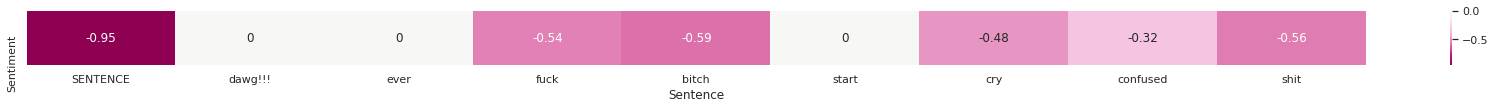

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,1)})
def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

sentence = df_result['detokenization_with_emoticons'][2]
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sentiment_analyzer.polarity_scores(sentence)["compound"]] + [sentiment_analyzer.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Number  of  words & sentences

To calculate the number of words and sentences that each tweet has, we have decided to use the original tweet, without preprocessing, since we think that it is more significant in this aspect than the already processed tweet, which removes words.

In [ ]:
from nltk.tokenize import word_tokenize

listNumberWords = []

for i in range(0,len(df['tweet'])):
  words = word_tokenize(df['tweet'][i])
  num_words = len(words)
  listNumberWords.append(num_words)

listNumberWords 

0        34
1        26
2        35
3        20
4        43
         ..
24778    39
24779    15
24780    17
24781     7
24782    25
Name: number_of_words, Length: 24783, dtype: int64

In [ ]:
from nltk.tokenize import sent_tokenize

listNumberSentences = []

for i in range(0,len(df['tweet'])):
  sentences = sent_tokenize(df['tweet'][i])
  num_sentences = len(sentences)
  listNumberSentences.append(num_sentences)

listNumberSentences

0        3
1        3
2        4
3        2
4        2
        ..
24778    4
24779    1
24780    2
24781    1
24782    2
Name: number_of_sentences, Length: 24783, dtype: int64

## TFIDF

In order to start using TFIDF, we will first have to create a TFIDFVectorizer.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. Three steps at once

In [8]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer,min_df=1,lowercase=False)

X_TFIDF = vectorizer.fit_transform(df['preprocessing_without_emoticons'])
X_POS = vectorizer.fit_transform(listaTweets_POS)

In [9]:
X = np.concatenate([X_TFIDF.toarray(), X_POS.toarray(), negative, positive, neutral, compound, listNumberWords, listNumberSentences],axis=1)

ValueError: ignored

# 3. Select features

We have created a new dataset where we have put the characteristics with which we will work from now on. With this dataset, feature selection will be made.

To carry out the selection of characteristics, the selectKBest function will be used. You will have to pass it the number of "top" characteristics that it will choose from the existing ones. As each column is a different word and in our problem we are asked to eliminate 70% of the words, we will only have 30% of our vocabulary.

In [35]:
# Create features and target variable for Classification problem
X_clf = X
y_clf = df['class'] # Target variable: class
n_k = round(X.shape[1] * 0.3)

best = SelectKBest(score_func = mutual_info_classif, k = n_k)

X_new = best.fit_transform(X_clf, y_clf)
print(X_new.shape)

selected = best.get_support(indices=True)
selected

ValueError: ignored

# 4. Classification algorithm

## Single Validation

Once we know the three characteristics with which we are going to work, it is time to separate the dataset records in the training part and the test part. The test part will be made up of 30% of the tweets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_clf, test_size=0.3, random_state=0)

## Model Execution



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### K-nearest neighbors algorithm

With this algorithm we are going to classify the tweets depending on the tweets closest to the one to be predicted.

In [ ]:
# Number of closest tweets that you will consult.
n_neighbors = 25
weights = 'distance'
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# Fit and predict
knn.fit(X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.843039677202421


Finally, we obtain the Confusion Matrix

**Confusion Matrix**

Normalized confusion matrix
[[4.21545667e-02 6.51053864e-01 3.06791569e-01]
 [2.43605359e-03 9.30920480e-01 6.66434662e-02]
 [7.93021412e-04 2.85487708e-01 7.13719270e-01]]


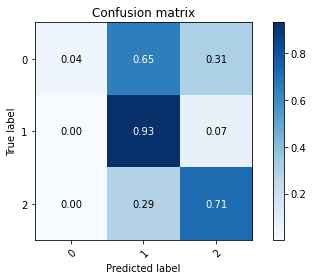

In [ ]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test, y_pred), normalize=True,
                      title='Confusion matrix')
  

**Classification Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.04      0.08       427
           1       0.89      0.93      0.91      5747
           2       0.64      0.71      0.67      1261

    accuracy                           0.84      7435
   macro avg       0.69      0.56      0.55      7435
weighted avg       0.83      0.84      0.82      7435



### Naive Bayes algorithm

This algorithm is based on Bayes' Theorem. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
#GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
clf = BernoulliNB() # Classifier chosen
clf.fit(X_train.toarray(), y_train)
y_pred = clf.predict( X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8886348352387357


**Confusion Matrix**

Normalized confusion matrix
[[0.19203747 0.69086651 0.11709602]
 [0.00783017 0.97372542 0.01844441]
 [0.00872324 0.25455987 0.73671689]]


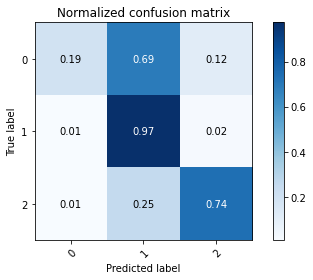

In [ ]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.19      0.29       427
           1       0.90      0.97      0.94      5747
           2       0.86      0.74      0.79      1261

    accuracy                           0.89      7435
   macro avg       0.78      0.63      0.67      7435
weighted avg       0.88      0.89      0.87      7435



### Cross validation.

In [ ]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=5, test_size=.3, random_state=0, train_size=0.7)

# Number of closest tweets that you will consult.
n_neighbors = 3
weights = 'distance'
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
cont = 0;
for train_index, test_index in rs.split(X_new):
  rs.get_n_splits()
  print("TRAIN[",cont,"]:", train_index, "TEST[",cont,"]:", test_index)
  X_train, X_test = X_new[train_index], X_new[test_index]
  y_train, y_test = y_clf[train_index], y_clf[test_index]
  # Fit and predict
  knn.fit(X = X_train, y = y_train)
  y_pred = knn.predict(X = X_test.toarray())
  acc = accuracy_score(y_test, y_pred)
  print ('Acc', acc)
  cont = cont +1
  title = 'Confusion matrix ' + str(cont)
  plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title=title)
  print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=5, test_size=.3, random_state=0, train_size=0.7)

cont = 0;
for train_index, test_index in rs.split(X_new):
  rs.get_n_splits()
  print("TRAIN[",cont,"]:", train_index, "TEST[",cont,"]:", test_index)
  X_train, X_test = X_new[train_index], X_new[test_index]
  y_train, y_test = y_clf[train_index], y_clf[test_index]
  # Fit and predict
  #GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
  clf = BernoulliNB() # Classifier chosen
  clf.fit(X_train.toarray(), y_train)
  y_pred = clf.predict(X_test.toarray())
  acc = accuracy_score(y_test, y_pred)
  print ('Acc', acc)
  cont = cont +1
  title = 'Confusion matrix ' + str(cont)
  plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title=title)
  print(classification_report(y_test, y_pred))

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.